In [102]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import pathlib
import idx2numpy

In [103]:
X_train = 'archive/train-images.idx3-ubyte'
y_train = 'archive/train-labels.idx1-ubyte'
X_test = 'archive/t10k-images.idx3-ubyte'
y_test = 'archive/t10k-labels.idx1-ubyte'

In [104]:
X_train = idx2numpy.convert_from_file(X_train)
y_train = idx2numpy.convert_from_file(y_train)
X_test = idx2numpy.convert_from_file(X_test)
y_test = idx2numpy.convert_from_file(y_test)

In [105]:
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [106]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [107]:
class LayerDense:
    def __init__(self,n_inputs,n_neurons):
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons)
        self.biases = np.zeros((1,n_neurons))

    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
        return self.output
    
    def backward(self,dvalues): 
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [161]:
class Activation_Relu:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
        return self.output
    def backward(self,dvalues): 
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [109]:
class Activation_Softmax: 
    def forward(self,layer_outputs): 
        exp_values = np.exp(layer_outputs - np.max(layer_outputs, keepdims= True, axis= 1))
        probabilities = exp_values / (np.sum(exp_values, keepdims=True, axis=1))
        self.output = probabilities
        return self.output
    
    def backward(self,dvalues): 
        self.dinputs = np.empty_like(dvalues)

        for index,(single_output, single_dvalues) in enumerate(zip(self.output,dvalues)): 
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)

In [110]:
class Loss: 
    def calculate(self, output, y): 
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true): 
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1: 
            correct_confidences = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2: 
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        neg_log_likelihoods = -np.log(correct_confidences)

        return neg_log_likelihoods
    
    def backward(self,dvalues,y_true): 
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1: 
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true/dvalues
        self.dinputs = self.dinputs/samples

In [117]:
class Activation_Softmax_Loss_CategoricalCrossEntropy: 
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self,inputs,y_true): 
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    
    def backward(self,dvalues,y_true): 
        samples = len(dvalues)

        if len(y_true.shape) == 2: 
            y_true = np.argmax(y_true,axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        self.dinputs = self.dinputs / samples

In [167]:
class Optimizer_SGD: 
    def __init__(self,lr=1.0):
        self.lr = lr 

    def update_params(self,layer): 
        layer.weights += -self.lr * layer.dweights 
        layer.biases += -self.lr * layer.dbiases

In [112]:
class Neural_Network(LayerDense, Activation_Relu, Activation_Softmax, Loss_CategoricalCrossEntropy): 
    def __init__(self,n_inputs,n_neurons,n_outputs):
        self.layer1 = LayerDense(n_inputs,n_neurons)
        self.layer2 = LayerDense(n_neurons,n_outputs)
        self.activation1 = Activation_Relu() 
        self.activation2 = Activation_Softmax()

    def forward(self,inputs): 
        self.Z1 = self.layer1.forward(inputs)
        self.A1 = self.activation1.forward(self.Z1)
        self.Z2 = self.layer2.forward(self.A1)
        self.A2 = self.activation2.forward(self.Z2)
        return self.A2

In [200]:
def test_prediction(index,model,X,y): 
    current_image = X[index:index+1]
    softmax_output = model.forward(current_image)
    prediction = np.argmax(softmax_output)
    label = y[index]
    print(f"Predictions: {prediction}")
    print(f"Label: {label}")

    current_image = current_image.reshape((28,28))
    plt.gray()
    plt.imshow(current_image, interpolation="nearest")
    plt.title(f"Predicted: {prediction}, Actual: {label}")
    plt.show()

In [174]:
model_1 = Neural_Network(784,10,10)
loss_fn = Activation_Softmax_Loss_CategoricalCrossEntropy() 
optimizer = Optimizer_SGD(lr=1.0) 

epochs = 10001 

for epoch in range(epochs): 
    softmax_output = model_1.forward(X_train)
    loss = loss_fn.forward(softmax_output,y_train)

    predictions = np.argmax(softmax_output, axis=1)
    if len(y_train.shape) == 2: 
        y_train = np.argmax(y_train,axis=1)
    accuracy = np.mean(predictions == y_train)

    if epoch % 100 == 0: 
        print(f"Epoch: {epoch}| Accuracy: {accuracy:.3f}| Loss: {loss} ")   

    loss_fn.backward(loss_fn.output, y_train)
    model_1.activation2.backward(loss_fn.dinputs)
    model_1.layer2.backward(model_1.activation2.dinputs)
    model_1.activation1.backward(model_1.layer2.dinputs)
    model_1.layer1.backward(model_1.activation1.dinputs)

    optimizer.update_params(model_1.layer1)
    optimizer.update_params(model_1.layer2)

Epoch: 0| Accuracy: 0.095| Loss: 2.3033748367721847 
Epoch: 100| Accuracy: 0.720| Loss: 1.7756359125714087 
Epoch: 200| Accuracy: 0.750| Loss: 1.7199918795989455 
Epoch: 300| Accuracy: 0.758| Loss: 1.708267585533508 
Epoch: 400| Accuracy: 0.763| Loss: 1.70241693780936 
Epoch: 500| Accuracy: 0.831| Loss: 1.642781535799706 
Epoch: 600| Accuracy: 0.843| Loss: 1.626054520810554 
Epoch: 700| Accuracy: 0.848| Loss: 1.6200229927009107 
Epoch: 800| Accuracy: 0.850| Loss: 1.616577843082599 
Epoch: 900| Accuracy: 0.852| Loss: 1.6141431746016452 
Epoch: 1000| Accuracy: 0.853| Loss: 1.6122396804081598 
Epoch: 1100| Accuracy: 0.855| Loss: 1.6106517528236557 


KeyboardInterrupt: 

Predictions: 6
Label: 6


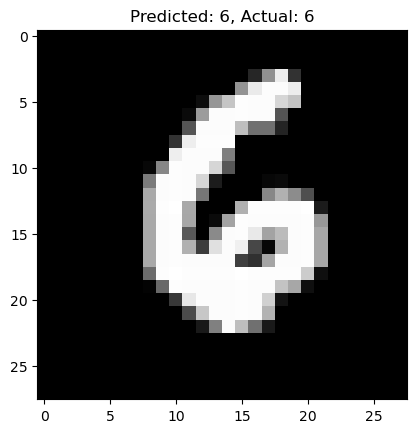

In [203]:
test_prediction(130,model_1,X_test,y_test)